## HyCReeW-Q : Overtopping estimation 

inputs required: 
  * Nearshore reconstructed historical storms
  * Nearshore reconstructed simulated storms
  * Historical water levels
  * Synthetic water levels 

in this notebook:
  * HyCReWW-Q overtopping estimation of historical and synthetic events
  * Extreme value analysis and validation

**HyCReWW - Q** provides wave-driven overtopping estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of overtopping for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_{reef}$, $\beta_b$, $c_f$, $Z_b$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), seabed roughness ($c_f$) and beach crest elevation ($Z_b$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period.

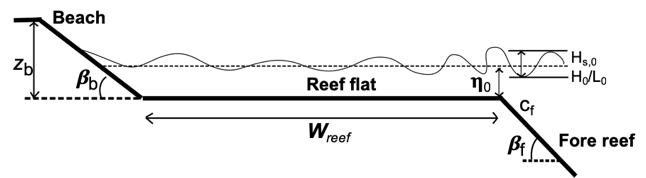

In [12]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize



## Database and Site parameters

In [3]:
# --------------------------------------
# Teslakit database

p_data = r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA'
path_coef=r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA\sites\MAJURO\HYCREWW\RBF_coefficients_Q'

db = Database(p_data)
db.SetSite('MAJURO')


# reef characteristics
# reef_cs = {
#     'rslope': 0.0505,
#     'bslope': 0.1667,
#     'rwidth': 250,
#     'Zr': 2.5,
#     'cf': 0.0105,
# }


# load Hycreww RBF coefficients and sim. variables min. and max.
var_lims, rbf_coeffs = db.Load_HYCREWW_Q(path_coef)


In [5]:
# HyCReWW Function

def hycreww_Q(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (WL, Hs, Tp, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf )
    
    '''
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf']

    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4, 5]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]


    # discard data outside limits
#     for vn in var_lims.keys():
#         dset = dset.isel(num=np.where((dset[vn] >= var_lims[vn][0]) & (dset[vn] <= var_lims[vn][1]))[0])


    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    ds_in=([dset.level.values],[dset.rslope.values],[dset.bslope.values],[dset.rwidth.values],[dset.Zb.values],[dset.cf.values])
    ds_in=np.transpose(ds_in)[:,0,:]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)

    # Q Linear interpolation (hs, hs_lo -> runup)
    Q = []
    for c  in range(len(dset.num)):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (dset.hs.values[c], dset.hs_lo2.values[c]), method='linear')
        Q.append(vq)
    Q = np.array(Q)

    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['Q'] = Q

    return dset_out


## Hycreww RBF Interpolation

### VARIABLES

##### WL, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf

In [4]:
data=np.loadtxt(os.path.join(path_coef,'Example_k15_variables.txt'))
dset = xr.Dataset(
            {   'hs':(('num'),data[:,1]),
                'level':(('num'),data[:,0]),
                'tp':(('num'), data[:,2]),
                'bslope':(('num'), data[:,4]),
                'rslope':(('num'), data[:,3]),
                'rwidth':(('num'), data[:,5]),
                'Zb':(('num'), data[:,6]),
                'cf':(('num'), data[:,7]),
            },coords = {'num':(('num'), np.arange(np.shape(data)[0]))})
dset['hs_lo2'] = (['num'],dset.hs.values/(1.5613*dset.tp.values**2))

### HyCReWW-Q

In [6]:
out_sim = hycreww_Q(var_lims, rbf_coeffs, dset)
out_sim

<xarray.Dataset>
Dimensions:  (Q: 4831, num: 4831)
Coordinates:
  * num      (num) int32 0 1 2 3 4 5 6 7 ... 4824 4825 4826 4827 4828 4829 4830
  * Q        (Q) float64 nan 2.9 11.7 -3.336 7.039 ... 15.75 -4.931 -4.931 14.47
Data variables:
    hs       (num) float64 1.0 4.0 4.0 3.0 3.0 5.0 ... 5.0 2.0 5.0 1.0 1.0 5.0
    level    (num) float64 1.0 1.5 0.5 -0.5 1.0 -0.5 ... 2.0 0.0 1.0 -1.0 0.5
    tp       (num) float64 3.579 22.64 22.64 19.6 ... 25.31 11.32 5.062 25.31
    bslope   (num) float64 0.1 0.05 0.05 0.1 0.05 0.1 ... 0.1 0.05 0.1 0.1 0.1
    rslope   (num) float64 0.5 0.05 0.1 0.1 0.5 0.5 ... 0.1 0.5 0.5 0.1 0.5 0.5
    rwidth   (num) float64 0.0 150.0 200.0 150.0 50.0 ... 50.0 100.0 100.0 150.0
    Zb       (num) float64 4.0 3.0 1.0 2.0 3.0 4.0 ... 2.0 2.0 2.0 4.0 4.0 2.0
    cf       (num) float64 0.05 0.05 0.1 0.05 0.05 ... 0.1 0.05 0.05 0.05 0.1
    hs_lo2   (num) float64 0.05 0.005 0.005 0.005 ... 0.005 0.005 0.025 0.005

### We undo the box-cox transformation

In [9]:
from scipy.special import boxcox, inv_boxcox
out_sim['Qinv']=inv_boxcox(out_sim.Q.values, 0.2)

In [10]:
# Data for validation
Qdata=np.loadtxt(os.path.join(path_coef,'Example_k15_Q.txt'))
Qdata=inv_boxcox(Qdata, 0.2)

### Plot

Text(0, 0.5, 'Data')

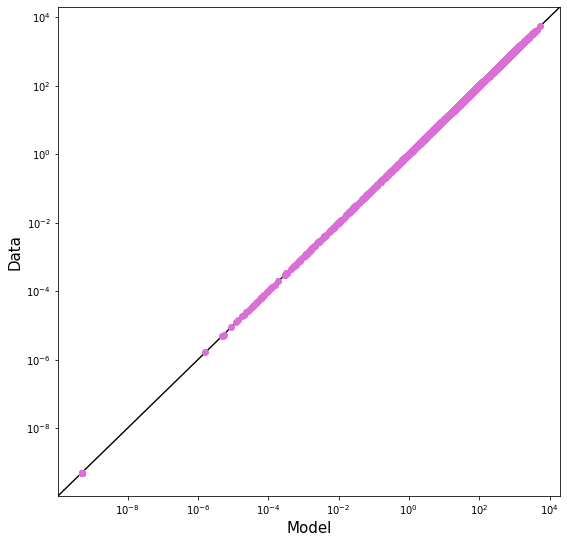

In [27]:
plt.figure(figsize=[9,9])
plt.loglog([0,20000],[0,20000],'k-',linewidth=1.4)
plt.loglog(out_sim.Qinv,Qdata,'.',color='orchid',markersize=12)
plt.axis([0, 20000, 0, 20000])
plt.xlabel('Model', fontsize=15)
plt.ylabel('Data', fontsize=15)